In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/Long_Data.csv', index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

In [ ]:
df.sample(n=7)

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
49909,2011-11-06,38,42469,43086,38232,283,1845,2,940,0,...,0,993,0,0,0,NaN,NaN,NaN,NaN,0
242234,2022-10-26,29,23798,29478,22478,3894,6545,4162,13861,0,...,-1028,-731,400,504,-620,-743.0,-1022.0,NaN,NaN,0
103712,2014-12-01,33,48893,50070,44440,390,4039,0,5905,49,...,0,1005,-185,-427,0,NaN,NaN,NaN,NaN,0
58599,2012-05-05,40,35583,36474,32323,265,2019,75,1484,0,...,0,993,-382,0,0,NaN,NaN,NaN,NaN,0
14503,2009-10-30,8,24447,27904,21988,753,1737,0,0,0,...,0,0,-45,0,0,NaN,NaN,NaN,NaN,0
241858,2022-10-18,37,33513,36678,30442,1318,6545,0,13861,0,...,-797,395,184,504,-57,1392.0,-1023.0,NaN,NaN,0
31502,2010-10-19,17,41792,43492,37957,1460,2121,1,57,0,...,0,0,-165,0,0,NaN,NaN,NaN,NaN,0


In [ ]:
df.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
count,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,...,267168.000000,267168.000000,267168.000000,267168.000000,267168.000000,91872.000000,91872.000000,21744.000000,21744.000000,267168.000000
mean,24.500225,31481.343331,32900.548730,28649.181062,1250.682492,4350.736885,831.076697,8287.481124,6.955489,311.277634,...,31.838963,521.535371,-117.552278,-38.061411,161.687470,319.934169,46.640184,1822.392292,109.798657,0.022637
std,13.853814,7798.869984,7700.569786,7066.753739,954.066159,1946.033161,1638.355773,5696.942896,40.001060,535.968754,...,331.032165,527.025721,228.075302,256.576114,406.115387,601.562333,452.463354,1923.805410,361.980818,0.148745
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,...,-1030.000000,-1215.000000,-505.000000,-585.000000,-1022.000000,-1455.000000,-1028.000000,-2851.000000,-1465.000000,0.000000
25%,12.750000,25236.000000,26885.000000,22968.000000,540.000000,2092.000000,0.000000,1957.000000,0.000000,8.000000,...,0.000000,0.000000,-279.000000,-170.000000,0.000000,0.000000,0.000000,291.000000,0.000000,0.000000
50%,24.500000,30868.000000,32108.000000,28088.000000,1000.000000,4276.000000,0.000000,11100.000000,0.000000,11.000000,...,0.000000,747.000000,-135.000000,0.000000,0.000000,0.000000,0.000000,1649.000000,0.000000,0.000000
75%,36.250000,37202.000000,38369.000000,33873.000000,1700.000000,6488.000000,799.000000,13080.000000,0.000000,397.000000,...,0.000000,994.000000,36.000000,0.000000,117.000000,693.000000,0.000000,3241.000000,0.000000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5587.000000,6574.000000,9830.000000,15954.000000,893.000000,2019.000000,...,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,6585.000000,1420.000000,1.000000


In [ ]:
df.shape

(267168, 22)

In [ ]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

In [ ]:
df.isna().any()

settlement_date              False
settlement_period            False
nd                           False
tsd                          False
england_wales_demand         False
embedded_wind_generation     False
embedded_wind_capacity       False
embedded_solar_generation    False
embedded_solar_capacity      False
non_bm_stor                  False
pump_storage_pumping         False
ifa_flow                     False
ifa2_flow                    False
britned_flow                 False
moyle_flow                   False
east_west_flow               False
nemo_flow                    False
nsl_flow                      True
eleclink_flow                 True
scottish_transfer             True
viking_flow                   True
is_holiday                   False
dtype: bool

As can be seen, only two columns include `nan` values. Let's check how many `nan` values there are in each column:

In [ ]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

,nsl_flow,eleclink_flow
True,175296,175296
False,91872,91872


It seems that both features have the same number of `nan` values. Let's have a look at that the dataframe containing the `nan` value:

In [ ]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,...,0,0,-161,0,0,NaN,NaN,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175291,2018-12-31,44,26826,28428,25195,2734,5918,0,13052,0,...,0,777,-454,-535,0,NaN,NaN,NaN,NaN,0
175292,2018-12-31,45,25660,27542,24145,2730,5918,0,13052,0,...,0,-268,-455,-536,0,NaN,NaN,NaN,NaN,0
175293,2018-12-31,46,25047,26971,23496,2726,5918,0,13052,0,...,0,-297,-455,-536,0,NaN,NaN,NaN,NaN,0
175294,2018-12-31,47,24188,26224,22683,2673,5918,0,13052,0,...,0,-467,-454,-466,0,NaN,NaN,NaN,NaN,0


In [ ]:
df.drop(columns=["nsl_flow", "eleclink_flow","viking_flow","scottish_transfer"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

### Bank holidays

In [ ]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

True


In [ ]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:10]

[numpy.datetime64('2009-01-01'),
 numpy.datetime64('2009-04-10'),
 numpy.datetime64('2009-04-13'),
 numpy.datetime64('2009-05-04'),
 numpy.datetime64('2009-05-25'),
 numpy.datetime64('2009-08-31'),
 numpy.datetime64('2009-12-25'),
 numpy.datetime64('2009-12-26'),
 numpy.datetime64('2009-12-28'),
 numpy.datetime64('2010-01-01')]

In [ ]:
holiday_dates_observed = pd.Series(holiday_dates_observed)
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed.values
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)


,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
147347,2017-05-29,6,19510,21579,17704,945,5143,3,12001,0,1569,1199,0,572,248,0,0,1
129904,2016-05-30,33,25527,26764,22482,1692,4260,3240,10500,0,6,1894,0,921,-210,-522,0,1
252524,2023-05-29,27,16309,17982,13874,1490,6538,9400,15517,0,194,1710,727,699,-453,-526,27,1
199791,2020-05-25,40,24636,25400,22443,1631,6527,726,13080,0,8,1607,0,715,-256,441,804,1
251197,2023-05-01,44,26791,28250,24228,871,6545,0,15407,0,15,1902,771,624,-444,-500,720,1
147368,2017-05-29,27,28623,29809,25626,850,5143,2080,12001,0,3,1646,0,345,-183,-500,0,1
60043,2012-06-05,4,23004,24753,20707,75,2065,0,1586,0,966,994,0,994,-283,0,0,1


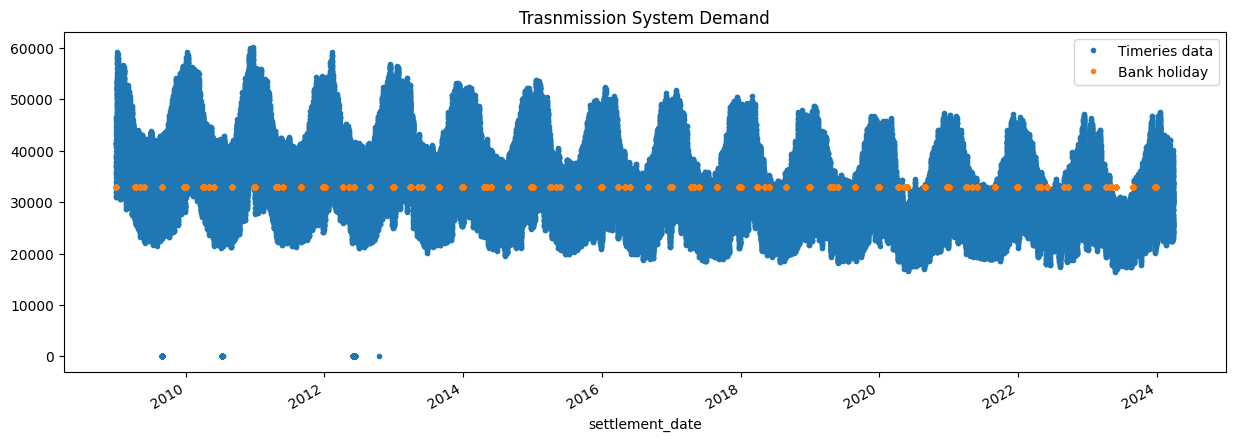

In [ ]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

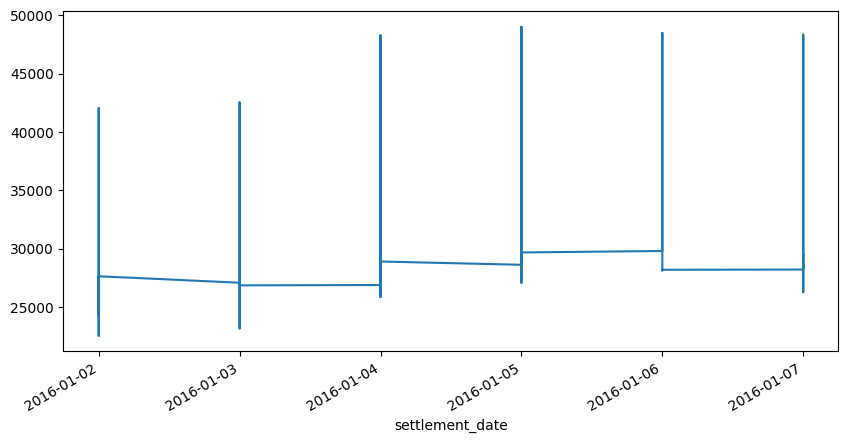

In [ ]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

In [ ]:
df_plot.head()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,
2009-01-01,1,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
2009-01-01,2,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2009-01-01,3,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
2009-01-01,4,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
2009-01-01,5,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


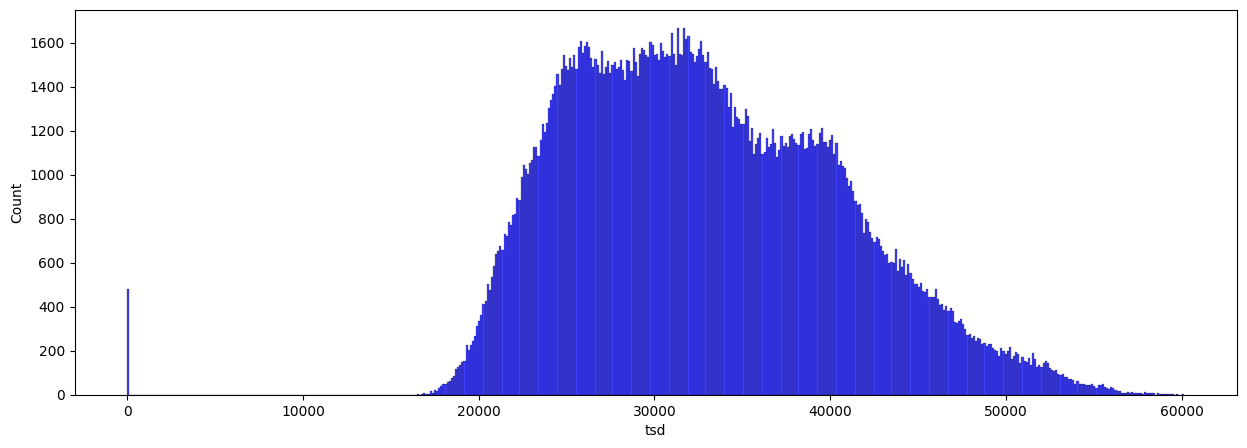

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

In [ ]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
256999,2023-09-14,38,18:30:00,30239,32740,27962,714,6538,167,15887,0,8,936,970,-870,-451,-527,-145,0
81869,2013-09-17,40,19:30:00,42537,43405,38768,685,2486,0,2978,73,11,1489,0,500,0,-430,0,0
193362,2020-01-27,41,20:00:00,40435,41506,36503,1868,6465,0,13080,0,10,2004,0,1057,-412,-49,1019,0
93216,2014-05-12,13,6:00:00,26796,27329,24276,347,2523,146,4693,0,33,1999,0,498,118,73,0,0
105520,2015-01-23,29,14:00:00,44920,46177,41188,2084,4067,964,6113,0,12,851,0,953,-175,-470,0,0
180326,2019-05-01,13,6:00:00,26909,27526,24254,215,6122,169,13080,0,25,1486,0,996,-92,0,925,0
22676,2010-04-20,25,12:00:00,41159,43597,37250,1304,1883,1,20,0,5,-1542,0,0,-391,0,0,0


As can be seen, a new column called `period_hour` includes the hour at which the electricity demand measurement was taken. One can now combine it with the actual date as follows:

In [ ]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
151973,2017-09-17 11:30:00,24,11:30:00,27918,28619,25079,733,5305,3590,12372,0,11,1000,0,992,-29,-162,0,0
5766,2009-05-01 04:00:00,9,4:00:00,25700,27611,23015,291,1673,0,0,0,1411,1987,0,0,61,0,0,0
61317,2012-07-15 14:30:00,30,14:30:00,30310,31068,27737,963,2085,620,1795,0,8,993,0,994,-250,0,0,0
86359,2013-12-20 08:30:00,18,8:30:00,43459,44467,39620,1194,2434,163,3301,48,16,1343,0,526,-84,-356,0,0
73773,2013-04-02 03:30:00,8,3:30:00,31120,33182,27678,608,2205,0,2597,0,1455,1486,0,647,-107,0,0,0


The `settlement_date` column is now in the right format to use an index:

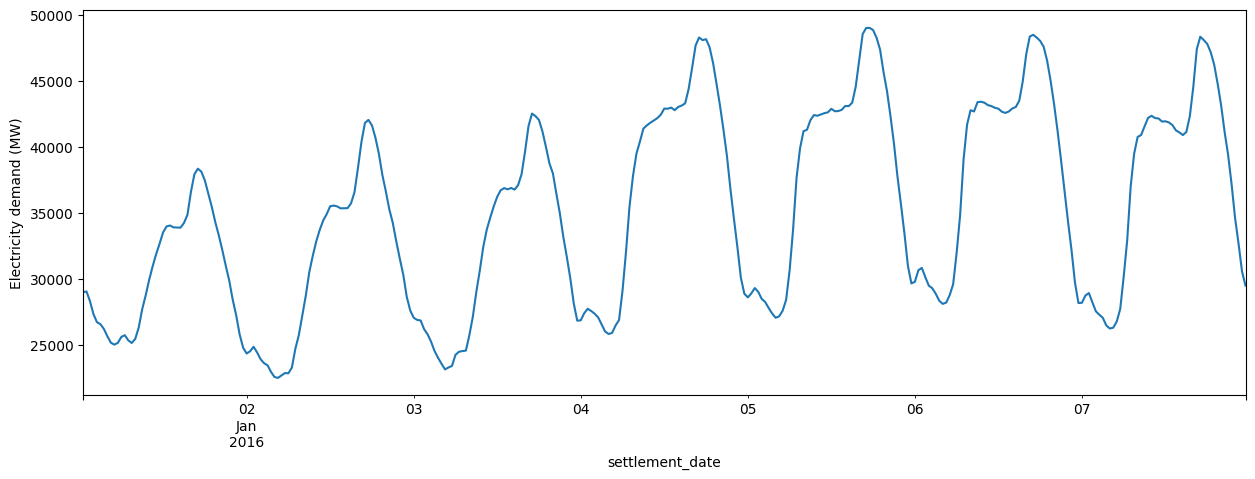

In [ ]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df['date'] = df.index
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300
    df['season'] = pd.cut(df['date_offset'], [0, 602,1300], labels=[0,1])
    return df

# [0, 300, 602, 900, 1300],
#labels=['Spring', 'Summer', 'Fall', 'Winter']
def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [ ]:
df = create_features(df)
df = add_lags(df)


df.sample(n=10)
df[df["year"] == 2022].shape

(17518, 31)

## Feature understanding



Although these are yearly average values, one can see a decreasing trend in the electricity consumption. We can overlay the electricity consumption of two years to see how they compare:

Again, this plot confirms that electricity consumption is decreasing in recent years.

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [ ]:
# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
threshold_date_1 = "01-01-2012"
threshold_date_2 = "01-01-2022"
threshold_date_3 = "01-01-2023"
threshold_date_4 = "01-01-2024"
train_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
test_data = df.loc[(df.index >= threshold_date_2) & (df.index < threshold_date_3)]
hold_out_data = df.loc[(df.index >= threshold_date_3) & (df.index < threshold_date_4)]

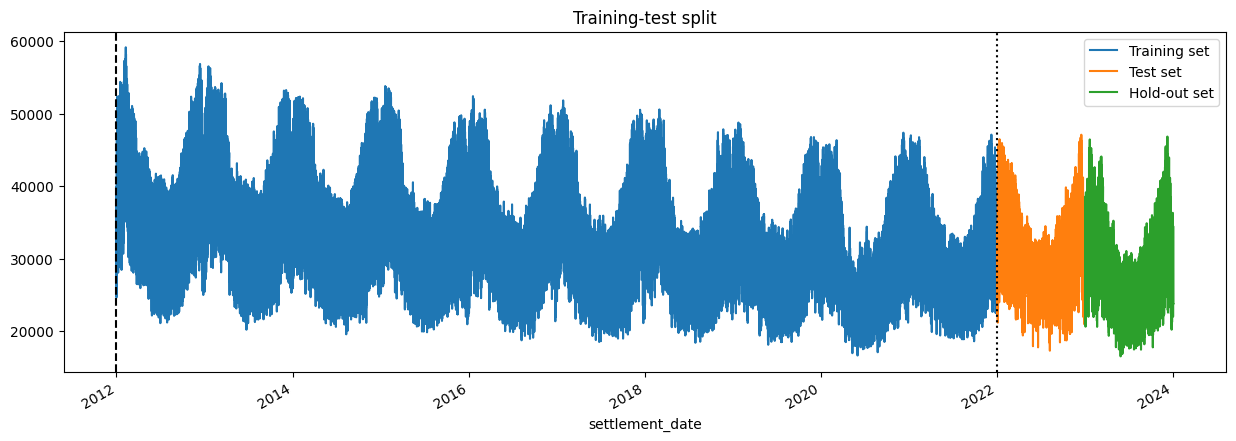

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [ ]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]

TARGET = "tsd"


# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    early_stopping_rounds=50,
#     tree_method="gpu_hist",
    random_state=43,
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
);


[0]	validation_0-rmse:7228.31744	validation_1-rmse:7286.31381
[100]	validation_0-rmse:4846.84711	validation_1-rmse:5415.98448
[200]	validation_0-rmse:3735.94498	validation_1-rmse:4289.25690
[300]	validation_0-rmse:3110.33302	validation_1-rmse:3682.97531
[400]	validation_0-rmse:2714.72251	validation_1-rmse:3386.25627
[499]	validation_0-rmse:2460.58239	validation_1-rmse:3208.56165


In [ ]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

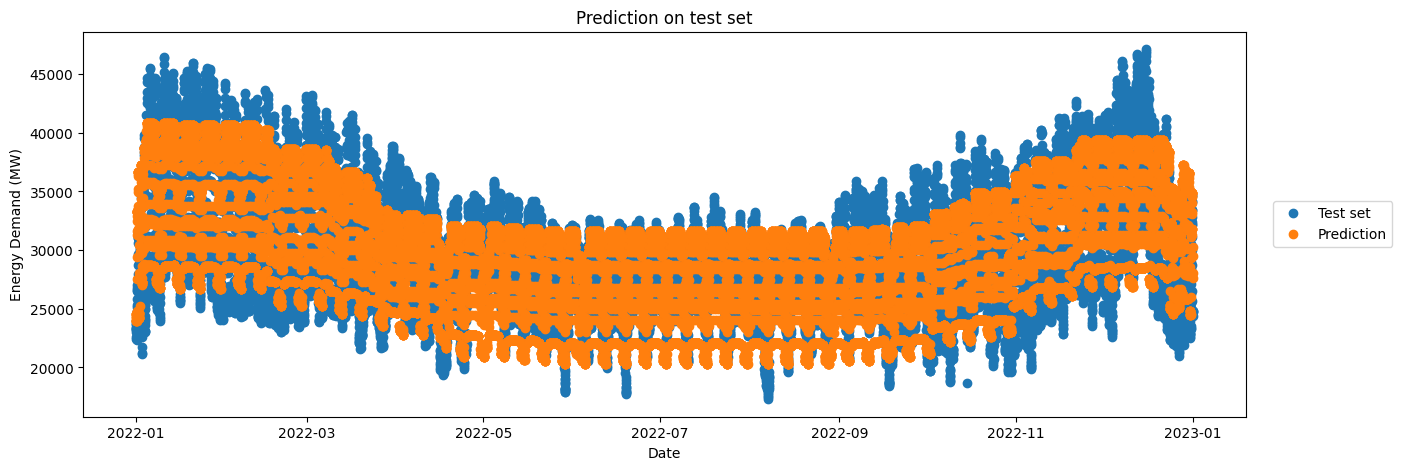

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

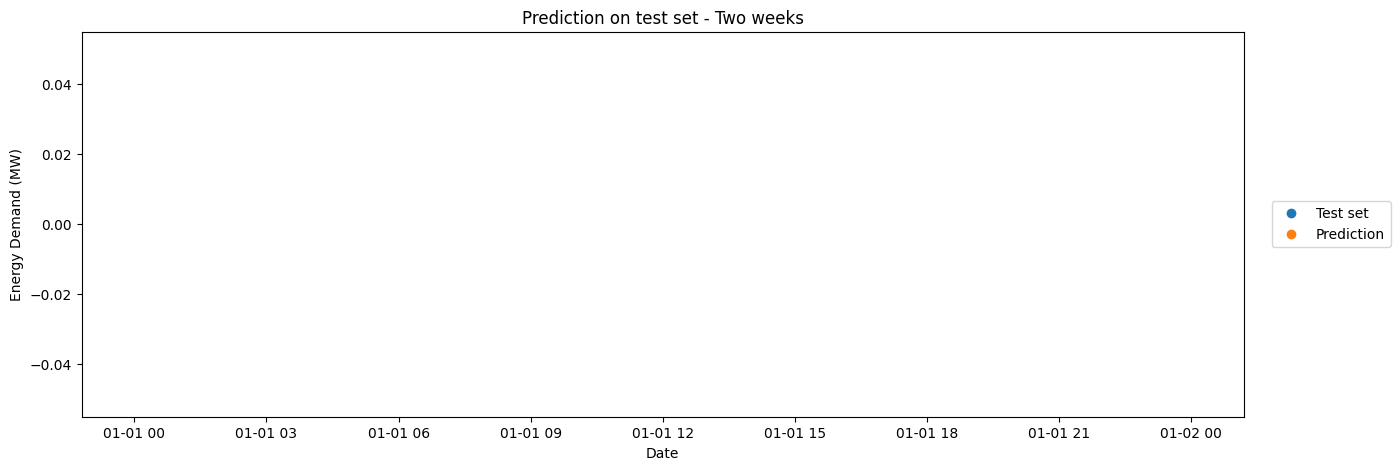

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)


Mean Absolute Percentage Error of the simple model is: 7.27
Root Mean Squared Error of the simple models is: 2570.87 MW


deep xgb

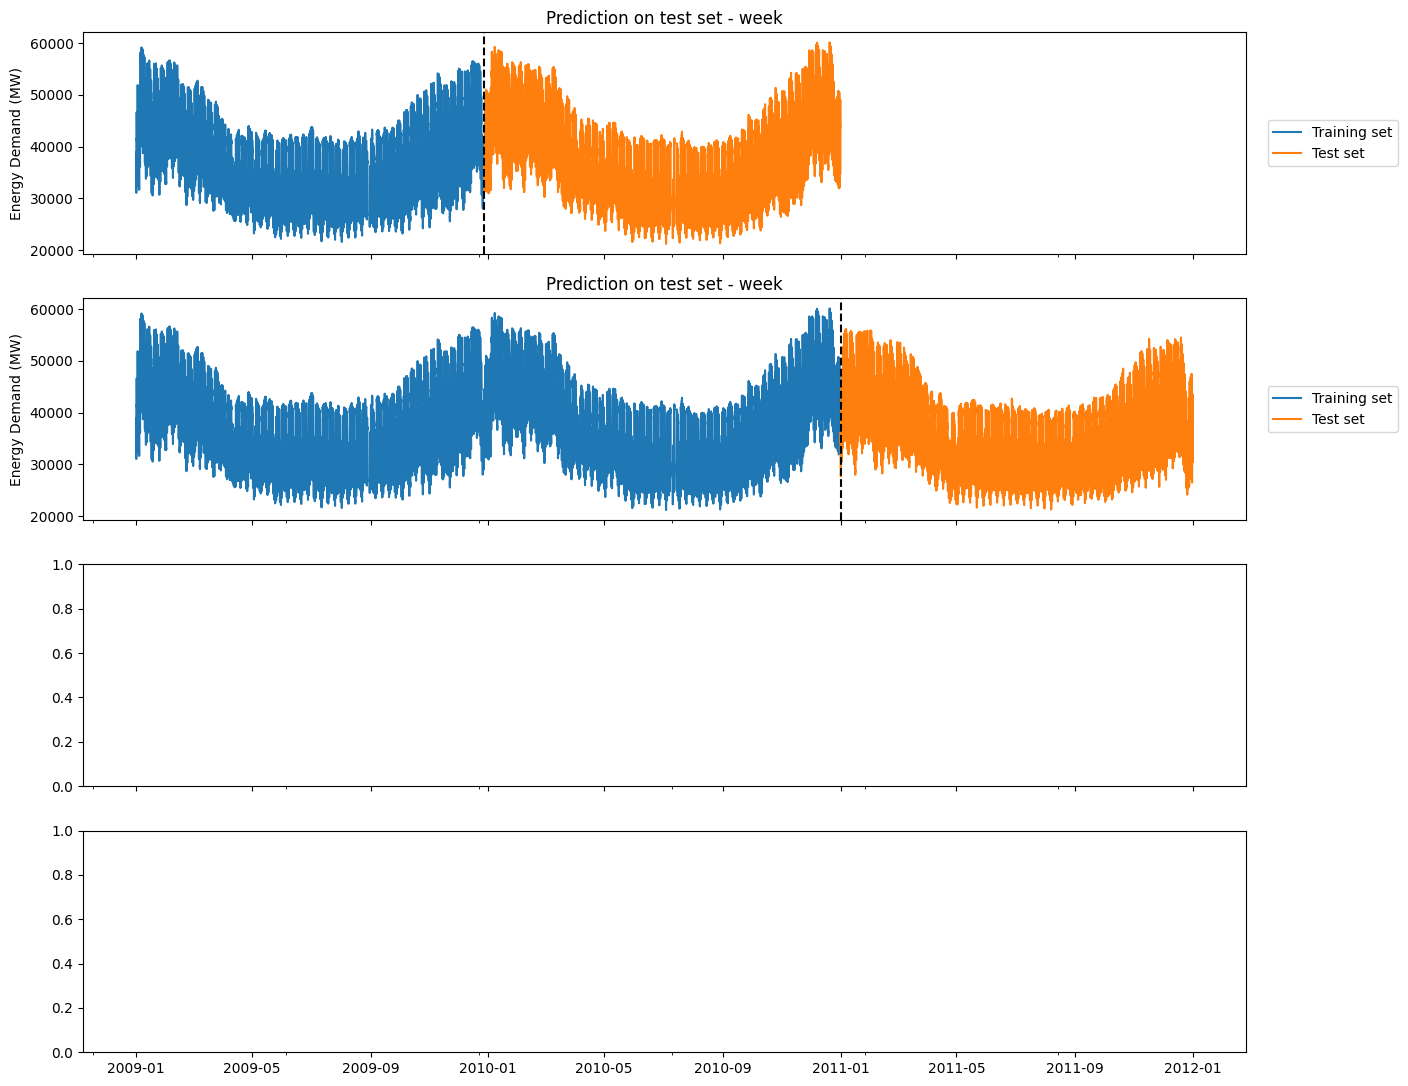

In [ ]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=2, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [ ]:
import warnings

def fxn():
    warnings.warn("FutureWarning", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

In [ ]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout

from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot


In [ ]:
%%time
train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]


# Define fit parameters to allow early stopping in GridSearchCV
fit_params = {
    "early_stopping_rounds": 50,
    "eval_metric": "rmse",
    "eval_set": [[X_hold_out, y_hold_out]],
}

# Define estimator
estimator = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    learning_rate=0.01,
    tree_method="gpu_hist",
    random_state=43,
)

# Define parameters to optimiser
param_search = {
    "max_depth": [3, 5],
    "n_estimators": [350, 500, 650],
    "subsample": [0.95, 0.8, 0.7],
}


# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

xgb_search.fit(X_train_cv, y_train_cv, verbose=500, **fit_params);

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[0]	validation_0-rmse:28193.94240
[349]	validation_0-rmse:2268.29060
[CV 1/2] END max_depth=3, n_estimators=350, subsample=0.95;, score=-2610.682 total time=   1.4s
[0]	validation_0-rmse:28199.03044
[349]	validation_0-rmse:2741.17657
[CV 2/2] END max_depth=3, n_estimators=350, subsample=0.95;, score=-3458.295 total time=   1.0s
[0]	validation_0-rmse:28193.98452
[349]	validation_0-rmse:2267.65772
[CV 1/2] END max_depth=3, n_estimators=350, subsample=0.8;, score=-2611.985 total time=   1.0s
[0]	validation_0-rmse:28199.00098
[349]	validation_0-rmse:2739.24165
[CV 2/2] END max_depth=3, n_estimators=350, subsample=0.8;, score=-3456.790 total time=   1.0s
[0]	validation_0-rmse:28194.02110
[349]	validation_0-rmse:2268.85518
[CV 1/2] END max_depth=3, n_estimators=350, subsample=0.7;, score=-2609.148 total time=   1.2s
[0]	validation_0-rmse:28198.83104
[349]	validation_0-rmse:2738.24268
[CV 2/2] END max_depth=3, n_estimators=350, subs

GridSearchCV(cv=TimeSeriesSplit(gap=48, max_train_size=None, n_splits=2, test_size=17520),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=Non...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=43, ...),
             param_grid={'max_depth': [3, 5], 'n_estimators': [350, 500, 650],
                         'subsample': [0.95, 0.8, 0.7]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
xgb_search.best_params_

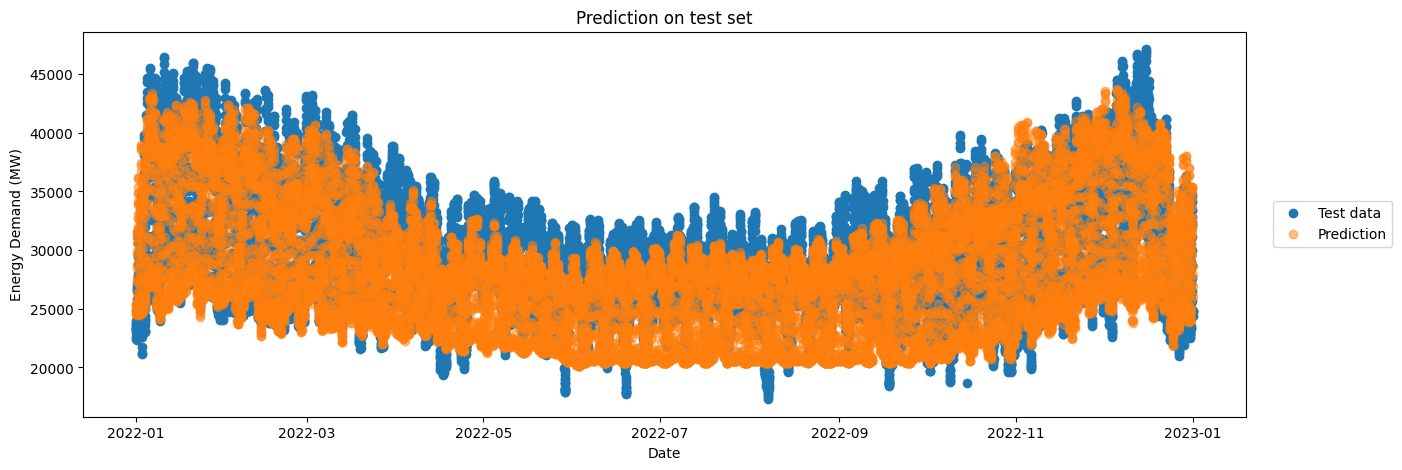

In [ ]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
mape_xgboost_cv = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_cv_gs"]
)

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

Mean Absolute Percentage Error of the cross-validated model is: 7.45
Root Mean Squared Error of the cross-validated model is: 2672.15 MW
